In [1]:
import pandas as pd
import numpy as np
import os
import re
from copy import deepcopy 

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_dir = 'data/english_only/prompting_results_clean/with_metrics/' #experiment 1
#base_dir = 'data/english_only/100k_results/with_metrics' #experiment 2

In [3]:
from aggregate_metrics_helper import *

In [4]:
os.chdir('/shared/0/projects/research-jam-summer-2024/')
pd.options.mode.copy_on_write = True

In [5]:
for f in os.listdir(base_dir):
    if f.startswith('wildchat_subset_en_2k_prompting') and not f.endswith('_end.jsonl') and not f.endswith('_embeddings.npz') and not f.endswith('lexical.jsonl') and not f.endswith('MERGED.jsonl') and not f.endswith('_POS_DEP.jsonl'):
        print(f)

wildchat_subset_en_2k_prompting_Qwen2-72B-Instruct.jsonl
wildchat_subset_en_2k_prompting_c4ai-command-r-v01.jsonl
wildchat_subset_en_2k_prompting_Mixtral-8x7B-Instruct-v0.1.jsonl
wildchat_subset_en_2k_prompting_Meta-Llama-3-70B-Instruct.jsonl
wildchat_subset_en_2k_prompting_Mistral-Large-Instruct.jsonl
wildchat_subset_en_2k_prompting_Phi-3-medium-4k-instruct.jsonl
wildchat_subset_en_2k_prompting_Mistral-7B-Instruct-v0.3.jsonl
wildchat_subset_en_2k_prompting_Meta-Llama-3.1-8B-Instruct.jsonl
wildchat_subset_en_2k_prompting_Meta-Llama-3.1-70B-Instruct.jsonl


In [6]:
metrics = pd.concat([make_human_vs_llm_df(f, base_dir) for f in os.listdir(base_dir)[:5]
                       if f.startswith('wildchat_subset_en_2k_prompting') and 
                       not f.endswith('_end.jsonl') and not f.endswith('_embeddings.npz') and 
                       not f.endswith('lexical.jsonl') and not f.endswith('MERGED.jsonl') and 
                       not f.endswith('_POS_DEP.jsonl')]).reset_index(drop=True)

wildchat_subset_en_2k_prompting_Qwen2-72B-Instruct.jsonl
read metrics
read dependency parse metrics
read embeddings
wildchat_subset_en_2k_prompting_c4ai-command-r-v01.jsonl
read metrics
read dependency parse metrics
read embeddings


In [7]:
# log scale heavy-tailed count metrics
for k in ['word_count', 'word_length', 'perplexity', 'dep_dpth', 'dep_brth', 'dep_dep_dist']:
    metrics['human_'+k] = np.log(metrics['human_'+k]+1)
    metrics['llm_'+k] = np.log(metrics['llm_'+k]+1)

In [8]:
# check that columns are exactly the merge keys and human/llm metrics from all_metrics 

print(Counter(['human_'+k in metrics.columns for k in all_metrics]))
print(Counter(['llm_'+k in metrics.columns for k in all_metrics]))
print(Counter([k in metrics.columns for k in merge_keys]))
print(Counter([k in merge_keys or re.sub('human_|llm_','',k) in all_metrics 
               for k in metrics.columns]))


Counter({True: 20})
Counter({True: 20})
Counter({True: 4})
Counter({True: 44})


In [9]:
metric_category = {}
for k in lexical: metric_category[k] = 'lexical'
for k in syntactic: metric_category[k] = 'syntactic'
for k in semantic: metric_category[k] = 'semantic'
for k in style: metric_category[k] = 'style'

In [10]:
def zscore_metric(p):
    print(p)
    
    # CREATE NORMALIZED SIMILARITIES BY Z-SCORE
    df_zscore = metrics[merge_keys]
    for k in all_metrics:
        df_zscore.loc[:,'zscore_'+k] = diff_zscore(metrics['human_'+k], metrics['llm_'+k], all_metrics[k], p)
        #sns.kdeplot(df_zscore['zscore_'+k])
        #plt.show()

    # AGGREGATED SCORES VIA Z-SCORE
    agg = aggregate_scores(df_zscore, method = 'zscore')
    agg['p'] = p
    return agg

1


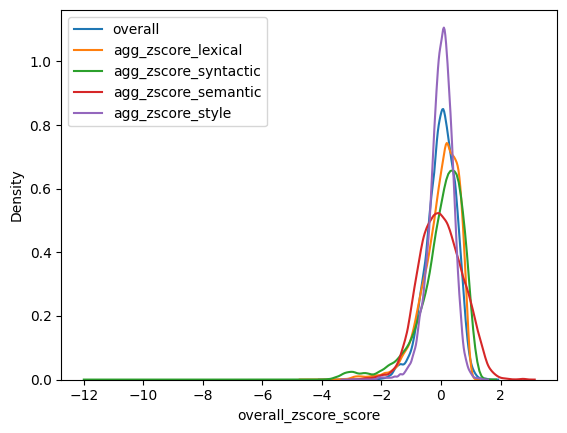

2


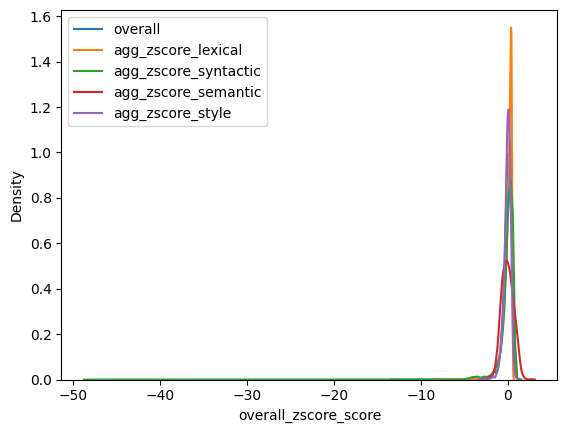

3


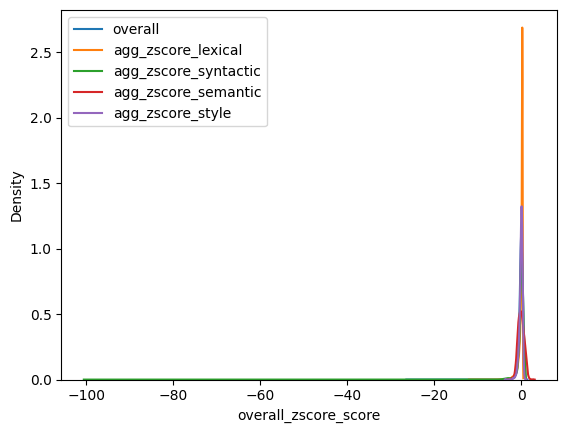

0.5


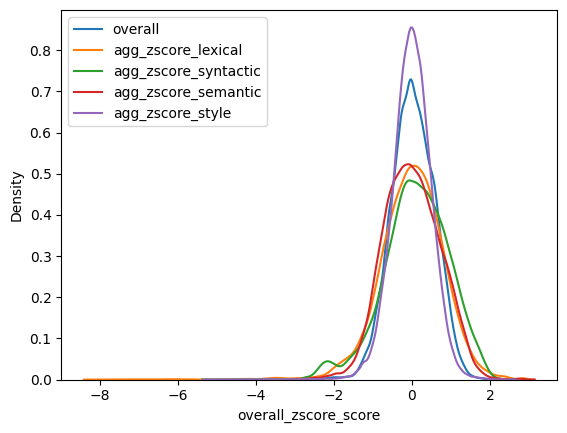

0.3333333333333333


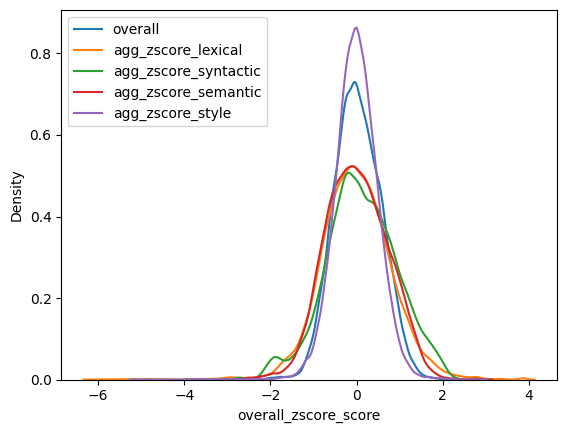

In [11]:
row_zscore = {p: zscore_metric(p) for p in [1, 2, 3, 1/2., 1/3.]}

In [12]:
# CREATE COLUMN AGGREGATES WITH CORRELATION
def corr_metric(corr_method):
    model = []
    metric = []
    cor = []
    for mod in set(metrics.model):
        print(mod)
        sub = metrics[metrics.model == mod]
        for k in all_metrics:
            model.append(mod)
            metric.append(k)
            cor.append(col_diff_correlate(sub['human_'+k], sub['llm_'+k], all_metrics[k], corr_method))
    col_corr = pd.DataFrame({'model': model, 'metric': metric, 'cor': cor, 'corr_method': corr_method})
    col_corr['category'] = col_corr['metric'].replace(metric_category)
    return col_corr

In [13]:
col_corr = {m: corr_metric(m) for m in ['pearson','spearman','kendall']}

wildchat_subset_en_2k_prompting_c4ai-command-r-v01
wildchat_subset_en_2k_prompting_Qwen2-72B-Instruct
wildchat_subset_en_2k_prompting_c4ai-command-r-v01
wildchat_subset_en_2k_prompting_Qwen2-72B-Instruct
wildchat_subset_en_2k_prompting_c4ai-command-r-v01
wildchat_subset_en_2k_prompting_Qwen2-72B-Instruct


In [42]:
p=1/2.
row_zscore_agg = row_zscore[p].groupby('model')[[c for c in row_zscore[p].columns if c.startswith('zscore_')]].mean()
#row_zscore_agg = row_zscore_agg.transpose().reset_index()#.rename(columns={'index':'metric'})
row_zscore_agg = pd.melt(row_zscore_agg.reset_index(), id_vars = ['model'], var_name = 'metric',
                            value_vars = row_zscore_agg.columns[row_zscore_agg.columns.str.startswith('zscore_')],
                            value_name = 'zscore')
row_zscore_agg['metric'] = row_zscore_agg['metric'].apply(lambda x: re.sub('zscore_','',x))
row_zscore_agg

,model,metric,zscore
0,wildchat_subset_en_2k_prompting_Qwen2-72B-Inst...,word_count,0.033991
1,wildchat_subset_en_2k_prompting_c4ai-command-r...,word_count,-0.035794
2,wildchat_subset_en_2k_prompting_Qwen2-72B-Inst...,word_length,0.008510
3,wildchat_subset_en_2k_prompting_c4ai-command-r...,word_length,-0.009054
4,wildchat_subset_en_2k_prompting_Qwen2-72B-Inst...,perplexity,-0.005893
5,wildchat_subset_en_2k_prompting_c4ai-command-r...,perplexity,0.004649
6,wildchat_subset_en_2k_prompting_Qwen2-72B-Inst...,typo,0.043747
7,wildchat_subset_en_2k_prompting_c4ai-command-r...,typo,-0.043196
8,wildchat_subset_en_2k_prompting_Qwen2-72B-Inst...,pos,0.009040
9,wildchat_subset_en_2k_prompting_c4ai-command-r...,pos,-0.009685


             cor    zscore
cor     1.000000 -0.151299
zscore -0.151299  1.000000


<Axes: xlabel='zscore', ylabel='cor'>

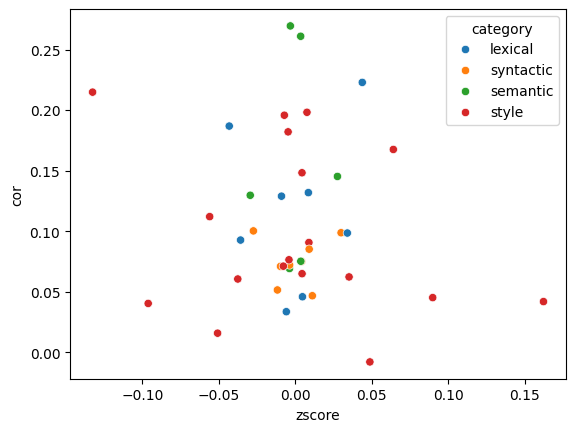

In [56]:
print(col_corr['pearson'].merge(row_zscore_agg, on=['model','metric'])[['cor','zscore']].corr())
sns.scatterplot(col_corr['pearson'].merge(row_zscore_agg, on=['model','metric']),
                x = 'zscore', y = 'cor', hue='category')

             cor    zscore
cor     1.000000 -0.012173
zscore -0.012173  1.000000


<Axes: xlabel='zscore', ylabel='cor'>

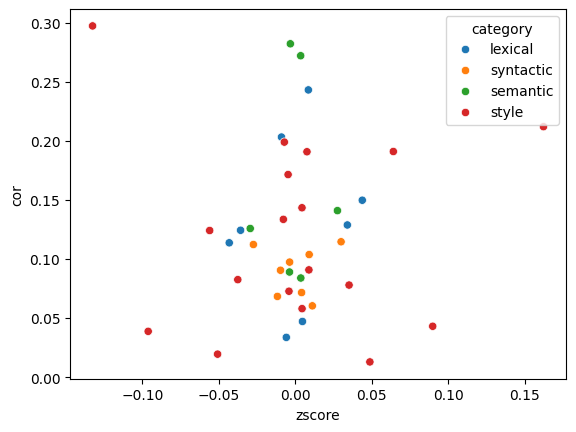

In [57]:
print(col_corr['spearman'].merge(row_zscore_agg, on=['model','metric'])[['cor','zscore']].corr())
sns.scatterplot(col_corr['spearman'].merge(row_zscore_agg, on=['model','metric']),
                x = 'zscore', y = 'cor', hue='category')

             cor    zscore
cor     1.000000 -0.019652
zscore -0.019652  1.000000


<Axes: xlabel='zscore', ylabel='cor'>

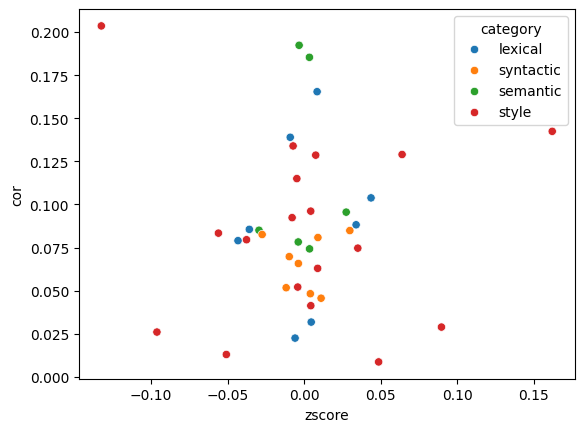

In [55]:
print(col_corr['kendall'].merge(row_zscore_agg, on=['model','metric'])[['cor','zscore']].corr())
sns.scatterplot(col_corr['kendall'].merge(row_zscore_agg, on=['model','metric']),
                x = 'zscore', y = 'cor', hue='category')

<Axes: xlabel='cor', ylabel='cor'>

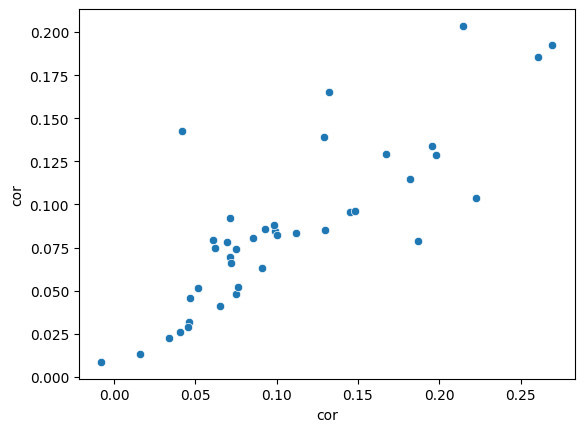

In [38]:
sns.scatterplot(x=col_corr['pearson']['cor'], y=col_corr['kendall']['cor'])

<Axes: xlabel='cor', ylabel='cor'>

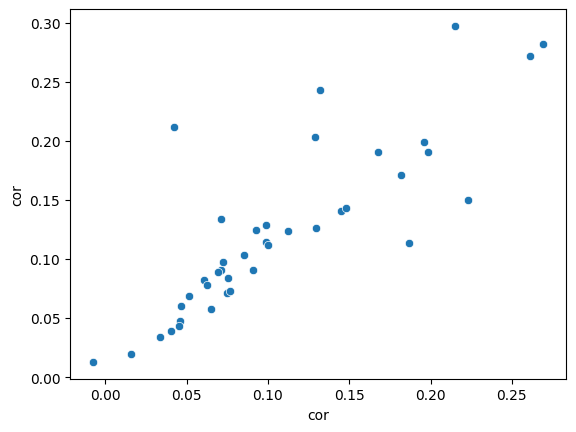

In [40]:
sns.scatterplot(x=col_corr['pearson']['cor'], y=col_corr['spearman']['cor'])

Text(0, 0.5, 'pearson')

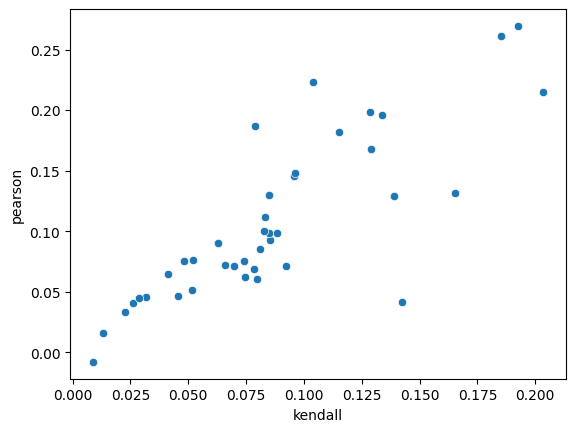

In [46]:
sns.scatterplot(x=col_corr['kendall']['cor'], y=col_corr['pearson']['cor'])
plt.xlabel('kendall')
plt.ylabel('pearson')
